In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/exp-6_of_cv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cd /content/drive/MyDrive/exp-6_of_cv && ls
! nvidia-smi

data_utils.py  __pycache__  test.py  train.py  xception.ipynb  xception.py
Thu Dec 18 05:41:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   49C    P8             16W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                      

In [4]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from xception import Xception
import os
from PIL import Image

In [5]:
# My Google Drive
DATA_ROOT = "/content/drive/MyDrive/adversarial_project/imagenet/"
SAMPLE_SIZE = 100
EPOCHS = 50
LEARNING_RATE = 0.001
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 1000
print(DEVICE)

cuda


In [6]:
def get_samples(root_dir, n_samples):

    subfolders = [f.path for f in os.scandir(root_dir) if f.is_dir()]
    all_images = []

    for folder in tqdm(subfolders, desc="Indexing classes"):
        imgs = glob.glob(os.path.join(folder, "*.[jJ][pP]*[gG]"))
        all_images.extend(imgs)

    total_imgs = len(all_images)
    print(f"Total {total_imgs} imgs。")

    return random.sample(all_images, n_samples)

class MiDaSe(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        parent_folder = os.path.basename(os.path.dirname(img_path))
        label = int(parent_folder)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

samples = get_samples(DATA_ROOT, SAMPLE_SIZE)

Indexing classes: 100%|██████████| 1000/1000 [00:00<00:00, 1479.91it/s]

Total 42561 imgs。


In [7]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
dataset = MiDaSe(samples, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Framework
def train(loader):
    model = Xception(num_classes = NUM_CLASSES)

    model = model.to(DEVICE)
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # LR 调度
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 40], gamma=0.1)

    loss_history = []
    acc_history = []

    for epoch in range(EPOCHS):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # 当前LR
        current_lr = scheduler.get_last_lr()[0]
        scheduler.step()

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = correct / total

        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}] | LR: {current_lr:.6f} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc*100:.2f}%")

    return loss_history, acc_history

Epoch [1/50] | LR: 0.001000 | Loss: 7.4901 | Acc: 0.00%
Epoch [5/50] | LR: 0.001000 | Loss: 2.8768 | Acc: 17.00%
Epoch [10/50] | LR: 0.001000 | Loss: 1.4680 | Acc: 66.00%
Epoch [15/50] | LR: 0.001000 | Loss: 0.9664 | Acc: 76.00%
Epoch [20/50] | LR: 0.001000 | Loss: 0.6290 | Acc: 83.00%
Epoch [25/50] | LR: 0.001000 | Loss: 0.4162 | Acc: 91.00%
Epoch [30/50] | LR: 0.000100 | Loss: 0.2457 | Acc: 96.00%
Epoch [35/50] | LR: 0.000100 | Loss: 0.1454 | Acc: 99.00%
Epoch [40/50] | LR: 0.000100 | Loss: 0.0855 | Acc: 100.00%
Epoch [45/50] | LR: 0.000010 | Loss: 0.1009 | Acc: 100.00%
Epoch [50/50] | LR: 0.000010 | Loss: 0.0968 | Acc: 99.00%


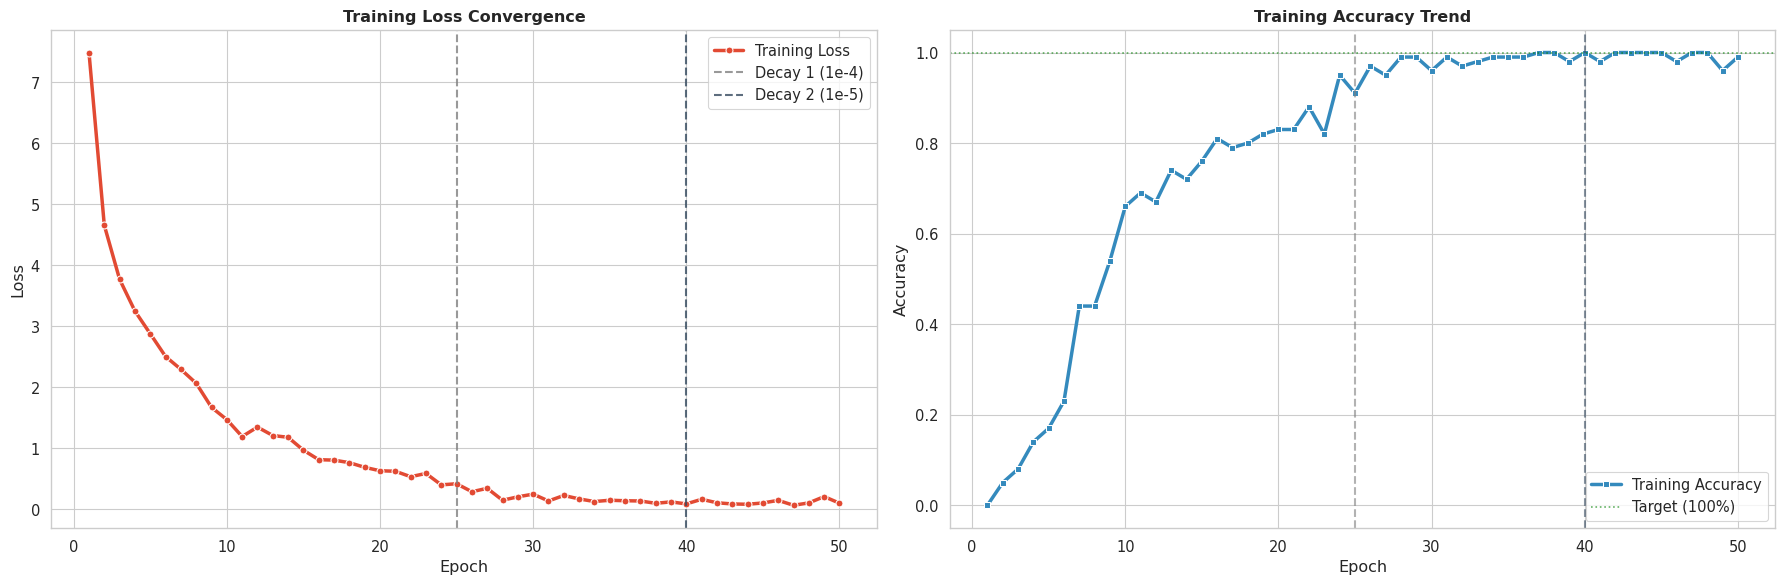

In [8]:
losses, accuracies = train(dataloader)

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Loss 曲线
sns.lineplot(
    x=range(1, len(losses) + 1),
    y=losses,
    ax=axes[0],
    linewidth=2.5,
    color="#E24A33",
    marker="o",
    markersize=5,
    label="Training Loss",
)

axes[0].axvline(x=25, color="gray", linestyle="--", alpha=0.8, linewidth=1.5, label="Decay 1 (1e-4)")
axes[0].axvline(x=40, color="#34495e", linestyle="--", alpha=0.8, linewidth=1.5, label="Decay 2 (1e-5)")

axes[0].set_title("Training Loss Convergence", fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Accuracy 曲线
sns.lineplot(
    x=range(1, len(accuracies) + 1),
    y=accuracies,
    ax=axes[1],
    linewidth=2.5,
    color="#348ABD",
    marker="s",
    markersize=5,
    label="Training Accuracy",
)

axes[1].axvline(x=25, color="gray", linestyle="--", alpha=0.6, linewidth=1.5)
axes[1].axvline(x=40, color="#34495e", linestyle="--", alpha=0.6, linewidth=1.5)
axes[1].axhline(y=1.0, color="green", linestyle=":", alpha=0.6, label="Target (100%)")

axes[1].set_title("Training Accuracy Trend", fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim(-0.05, 1.05)
axes[1].legend()

plt.tight_layout()
plt.show()